In [2]:
import arviz as az
import numpyro
from numpyro.infer import Predictive, log_likelihood
import jax
import jax.random as random
import jax.numpy as jnp
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from tqdm.notebook import tqdm

# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
import bnns.model_configs
from bnns.rasmus_bnn import LATENT
from datasets.synthetic import SyntheticDataset
from datasets.uci import UCIDataset, dataset_names, load_standard_splits
from utils import normalize, check_test_normed

plt.style.use("seaborn-v0_8-whitegrid")

In [3]:
%load_ext autoreload
%autoreload 2

In [125]:
# Adjust as needed
#SAMPLE_PATH = "../samples/2025-03-11T11:57:19.838834" # Golden standar (Ola)
SAMPLE_PATH = "../samples/uci-0" # My version
#SAMPLE_PATH = SAMPLE_PATH + "/HMC"
SEED = 10

In [126]:
# Load samples
def load_samples():
    methods = os.listdir(SAMPLE_PATH)
    methods = [method for method in methods if os.path.isdir(os.path.join(SAMPLE_PATH, method))]
    samples = []
    for method in methods:
        datasets_in_dir = os.listdir(os.path.join(SAMPLE_PATH, method))
        for dataset_name in datasets_in_dir:
            path = os.path.join(SAMPLE_PATH, method, dataset_name)
            if method == "SVI":
                splits = os.listdir(path)
                for split in splits:
                    with open(os.path.join(path, split), "rb") as f:
                        svi_result = dill.load(f)
                    model_name = "_".join(split.split(".")[0].split("_")[:-1])
                    split_ind = split.split(".")[0].split("_")[-1]
                    model = getattr(bnns.model_configs, model_name)
                    params = svi_result["params"]
                    guide = svi_result["guide"]
                    predictive = Predictive(guide, params=params, num_samples=1)
                    post_draws = predictive(jax.random.PRNGKey(SEED), None)
                    samples.append({
                        "dataset": dataset_name,
                        "model": model,
                        "method": method,
                        "method_name": "MAP" if method == "SVI" else "NUTS" if method == "HMC" else method,
                        "model": model_name,
                        "split": split_ind,
                        "post_draws": post_draws
                    })
            if method == "HMC":
                splits = os.listdir(path)
                for split in splits:
                    if ".nc" not in split:
                        continue
                    inference_data = az.from_netcdf(os.path.join(path, split))
                    model_name = "_".join(split.split(".")[0].split("_")[:-1])
                    split_ind = split.split(".")[0].split("_")[-1]
                    model = getattr(bnns.model_configs, model_name)

                    post_draws = inference_data.to_dict()["posterior"]
                    post_draws.pop("y_probs", None)

                    with open(os.path.join(path, split.replace(".nc", "_metadata.dill")), "rb") as f:
                        metadata = dill.load(f)
                    samples.append({
                        "dataset": dataset_name,
                        "model": model,
                        "method": method,
                        "method_name": "MAP" if method == "SVI" else "NUTS" if method == "HMC" else method,
                        "model": model_name,
                        "split": split_ind,
                        "post_draws": post_draws,
                        "inference_data": inference_data,
                        "time_spanned": metadata["time_spanned"],
                        "accept_prob": metadata["accept_prob"],
                    })
    return samples
samples = load_samples()

In [66]:
def get_dataset(dataset_name, split_ind):
    # Load dataset
    dataset = UCIDataset(dataset_name)
    X, y = dataset.X, dataset.y
    split = dataset.splits[split_ind]
    X_train, y_train = X[split["tr"]], y[split["tr"]]
    X_train, X_mean, X_std = normalize(X_train, None, None)
    X_test, y_test = X[split["te"]], y[split["te"]]
    X_test, _, _ = normalize(X_test, X_mean, X_std)
    check_test_normed(X_test)
    return X_train, y_train, X_test, y_test

# Load models

In [57]:
models = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-3:] == ".nc":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                print(file_name)
                az_data = az.from_netcdf(os.path.join(SAMPLE_PATH, dataset_name, file_name))
                samples = az_data.to_dict()["posterior"]
                y_loc = samples.pop("y_loc", None)
                models.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "az_data": az_data, "samples": samples, "y_loc": y_loc})
print(f"Loaded {len(models)} models")

Loaded 0 models


# Load models from Ola's code

In [4]:
import dill
models = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-5:] == ".dill":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                with open(os.path.join(SAMPLE_PATH, dataset_name, file_name), "rb") as f:
                    model_info = dill.load(f)
                samples = model_info["post_draws"]
                samples.pop("y_loc", None)
                models.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "samples": samples})
print(f"Loaded {len(models)} models")

KeyError: 'UCI_Full_FFT_CBNN_50_0'

[{'model': 'UCI_Full_FFT_CBNN_50',
  'method': 'HMC',
  'method_name': 'NUTS',
  'split': '0',
  'post_draws': {'b0': array([[[-0.5695685 ,  0.62224853,  0.5977879 , ...,  0.01381485,
            -0.38169047,  0.31856847],
           [-0.65598774,  0.96161205,  0.82920325, ..., -0.73856765,
            -0.38507876,  0.59980106],
           [-0.47685647, -0.16086563,  0.82483757, ..., -0.59255505,
            -0.2840334 ,  0.41191986],
           ...,
           [ 0.72028035,  0.7443546 , -1.9373544 , ...,  1.9885236 ,
            -0.2032872 ,  0.27071527],
           [-0.03444642,  0.807541  , -1.914429  , ...,  0.91301006,
            -0.8406416 , -0.27504456],
           [ 0.07861288,  0.5862175 , -2.1049187 , ...,  1.1489431 ,
            -0.38498223,  0.15954787]]], shape=(1, 3000, 50), dtype=float32),
   'b1': array([[[ 0.15347664, -0.82086855, -0.613699  , ..., -1.5811594 ,
             1.2051657 ,  1.0670422 ],
           [ 0.66395044, -0.4511453 , -1.4086664 , ..., -0.26620215,

# Compute Negative-Log-Likelihood, RMSE
To compare with Stein paper, Table 2

In [127]:
table_df = []
preds = []
for sample_dict in tqdm(samples):
    dataset_name = sample_dict["dataset"]
    model_name = sample_dict["model"]
    split_ind = sample_dict["split"]
    post_draws = sample_dict["post_draws"].copy()
    method = sample_dict["method"]

    # Get latent variable keys
    latent = list(post_draws.keys())

    if method == "HMC":
        batch_ndims = 2
    else:
        batch_ndims = 1

    post_draws_no_chain = {} 
    for key in post_draws:
        assert post_draws[key].shape[0] == 1
        post_draws_no_chain[key] = post_draws[key][0]
    # batch_ndims = 1
    # post_draws = post_draws_no_chain


    # Load dataset
    X_train, y_train, X_test, y_test = get_dataset(dataset_name, int(split_ind))

    # Load model
    model = getattr(bnns.model_configs, model_name)

    # Remove "y_loc" from posterior samples
    post_draws.pop("y_loc", None)

    # Compute NLL
    train_nll = log_likelihood(model, post_draws, X=X_train, y=y_train, batch_ndims=batch_ndims)["y"]
    train_nll = jax.scipy.special.logsumexp(train_nll, axis=-2) - jnp.log(train_nll.shape[-2]) # Estimate log-posterior-predictive
    train_nll_mean = -train_nll.mean()
    train_nll_std = train_nll.std()

    nll_posterior = Predictive(model, post_draws, return_sites=latent, batch_ndims=batch_ndims)
    nll_posterior_draws = nll_posterior(jax.random.PRNGKey(42), X=X_test, y=None, D_Y=1)
    test_nll = log_likelihood(model, nll_posterior_draws, X=X_test, y=y_test, batch_ndims=batch_ndims)["y"]
    test_nll = jax.scipy.special.logsumexp(test_nll, axis=-2) - jnp.log(test_nll.shape[-2]) # Estimate log-posterior-predictive
    test_nll_mean = -test_nll.mean()
    test_nll_mean_std = test_nll.std()

    # Compute RMSE
    predictive = Predictive(model, post_draws, return_sites=["y_loc"], batch_ndims=batch_ndims)
    predictions_train = predictive(jax.random.PRNGKey(SEED), X_train, D_Y=1)["y_loc"]
    predictions_test = predictive(jax.random.PRNGKey(SEED), X_test, D_Y=1)["y_loc"]

    rmse_train = jnp.sqrt(jnp.mean((predictions_train - y_train) ** 2, axis=-1))
    rmse_train_mean = rmse_train.mean()
    rmse_train_std = rmse_train.std()

    rmse_test = jnp.sqrt(jnp.mean((predictions_test - y_test) ** 2, axis=-1))
    rmse_test_mean = rmse_test.mean()
    rmse_test_std = rmse_test.std()

    table_df.append({
        "method": method,
        "dataset": dataset_name,
        "model": model_name,
        "split": split_ind,
        "train_nll_mean": train_nll_mean,
        "train_nll_std": train_nll_std,
        "test_nll_mean": test_nll_mean,
        "test_nll_std": test_nll_mean_std,
        "rmse_train_mean": rmse_train_mean,
        "rmse_train_std": rmse_train_std,
        "rmse_test_mean": rmse_test_mean,
        "rmse_test_std": rmse_test_std
    })

    preds.append({
        "dataset": dataset_name,
        "model": model_name,
        "split": split_ind,
        "predictions_train": predictions_train,
        "predictions_test": predictions_test,
        "y_train": y_train,
        "y_test": y_test
    })
table_df = pd.DataFrame(table_df)
table_df


  0%|          | 0/225 [00:00<?, ?it/s]

,method,dataset,model,split,train_nll_mean,train_nll_std,test_nll_mean,test_nll_std,rmse_train_mean,rmse_train_std,rmse_test_mean,rmse_test_std
0,SVI,concrete,UCI_BNN_50,17,2.9568307,9.933413,8.906183,29.771294,2.5114746,0.0,5.27869,0.0
1,SVI,concrete,UCI_Full_FFT_CBNN_50,0,2.7392411,1.2604249,3.71827,2.6866632,3.7208843,0.0,6.087558,0.0
2,SVI,concrete,UCI_Full_FFT_CBNN_50,9,2.8516498,1.3177807,3.1753066,1.7160223,4.166741,0.0,5.203476,0.0
3,SVI,concrete,UCI_Full_FFT_CBNN_50,11,2.805623,1.4998184,3.6837125,8.07638,3.9479158,0.0,6.1214,0.0
4,SVI,concrete,UCI_Full_FFT_CBNN_50,6,2.7657223,1.7322203,3.1458015,1.9143624,3.7637813,0.0,4.7238812,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
220,HMC,boston-housing,UCI_Full_Spectral_BNN_50,0,1.9083503,0.6621715,2.2965703,1.8380824,1.9236394,0.083935596,2.687634,0.2055801
221,HMC,boston-housing,UCI_Full_Spectral_BNN_50,1,1.8787541,0.6093119,2.3650572,2.0264614,2.1306224,0.1913366,2.9380774,0.24959569
222,HMC,boston-housing,UCI_Full_Spectral_BNN_50,2,2.006783,0.93286085,2.120199,0.5752291,2.2707906,0.11558655,2.657936,0.3848233
223,HMC,boston-housing,UCI_Full_Spectral_BNN_50,3,1.9711822,0.62174964,2.2225213,0.86484677,2.0900328,0.11899045,2.8045702,0.26910168


In [15]:
table = [{"dataset": x["dataset"], "model": x["model"], "split": x["split"]} for x in models]
for row, d in zip(models, table):
    dataset = UCIDataset(d["dataset"])
    splits = load_standard_splits(True)[d["dataset"]]
    samples = row["samples"].copy()

    # Important: Squeeze out the redundant chain dimension
    for key in samples:
        assert samples[key].shape[0] == 1
        samples[key] = samples[key][0]

    model = bnns.model_configs.__dict__[row["model"]]
    train_split = splits[d["split"]]["tr"]
    test_split = splits[d["split"]]["te"]

    #X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    X = dataset.X
    train_X, mean_X, std_X = normalize(X[train_split], None, None)

    assert train_X.mean().item() < 1e-5
    assert train_X.std().item() - 1.0 < 1e-5
    train_y = dataset.y[train_split]
    test_X, _, _ = normalize(X[test_split], mean_X, std_X)
    test_y = dataset.y[test_split]
    check_test_normed(train_X)

    # train_X = X[train_split]
    # train_y = y[train_split]
    # test_X = X[test_split]
    # test_y = y[test_split]

    train_nll = -log_likelihood(model, samples, X=train_X, y=train_y.flatten(), batch_ndims=1)["y"]
    # print(test_X.shape, test_y.shape)
    test_nll = -log_likelihood(model, samples, X=test_X, y=test_y.flatten(), batch_ndims=1)["y"]

    predictive = Predictive(model, posterior_samples=samples, return_sites=["y_loc"], batch_ndims=1)
    # print(samples.keys())
    predicted_ys = predictive(model_key, X=train_X, y=None, D_Y=1)["y_loc"]
    train_rmse = jnp.sqrt(((train_y - predicted_ys[0])**2).mean())

    predictive = Predictive(model, posterior_samples=samples, return_sites=["y_loc"], batch_ndims=1)
    predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y_loc"]
    test_rmse = jnp.sqrt(((test_y - predicted_ys[0])**2).mean())

    #d["train_nll"] = train_nll.mean()
    LATENT = list(row["samples"].keys())
    nll_post_samples = Predictive(model, posterior_samples=samples, return_sites=LATENT, batch_ndims=1)(random.PRNGKey(42), X=train_X, y=None, D_Y=1)
    assert jnp.allclose(nll_post_samples["b0"][:5], samples["b0"][:5])
    d["train_nll"] = nll_reg_fn(nll_post_samples, model, train_X, train_y, 1)
    nll_post_samples = Predictive(model, posterior_samples=samples, return_sites=LATENT, batch_ndims=1)(random.PRNGKey(42), X=test_X, y=None, D_Y=1)
    d["test_nll"] = nll_reg_fn(nll_post_samples, model, test_X, test_y, 1)
    d["train_rmse"] = train_rmse.item()
    d["test_rmse"] = test_rmse.item()
table_df = pd.DataFrame(table)
table_df

""


In [105]:
table_df.loc[(table_df["model"] == "UCI_BNN_50") & (table_df["dataset"] == "boston-housing")]

,method,dataset,model,split,train_nll_mean,train_nll_std,test_nll_mean,test_nll_std,rmse_train_mean,rmse_train_std,rmse_test_mean,rmse_test_std
60,SVI,boston-housing,UCI_BNN_50,17,310.34976,1263.1451,5328.651,11042.566,1.287925,0.0,5.320219,0.0
65,SVI,boston-housing,UCI_BNN_50,19,265.46622,1339.9662,3458.198,7942.3477,1.2559988,0.0,4.517619,0.0
71,SVI,boston-housing,UCI_BNN_50,11,304.77115,1410.3138,1587.4679,4799.7417,1.5958614,0.0,3.6334145,0.0
74,SVI,boston-housing,UCI_BNN_50,0,383.22464,2187.27,3083.6301,7319.4077,1.5339124,0.0,4.341371,0.0
83,SVI,boston-housing,UCI_BNN_50,12,405.2109,1778.63,3260.7197,5622.7983,1.3933975,0.0,3.9437397,0.0
85,SVI,boston-housing,UCI_BNN_50,5,1014.4258,5839.684,3094.6245,4766.9023,2.3461175,0.0,4.094972,0.0
91,SVI,boston-housing,UCI_BNN_50,6,401.89496,2640.2488,2362.4287,5233.943,1.5244337,0.0,3.6883705,0.0
92,SVI,boston-housing,UCI_BNN_50,13,422.02893,2653.788,3464.4272,6595.2104,1.5302259,0.0,4.3750863,0.0
93,SVI,boston-housing,UCI_BNN_50,3,373.68875,1801.3862,1928.6335,3201.2295,1.3218001,0.0,2.9960492,0.0
95,SVI,boston-housing,UCI_BNN_50,16,226.03783,1091.8469,4120.903,8703.233,1.3151338,0.0,5.593539,0.0


# Grouped stats
**Important:** Standard deviation is denoted as the variance between mean of splits

In [128]:
table_df["split"] = table_df["split"].astype(int)
grouped = table_df.groupby(["method", "dataset", "model"]).mean()
stds = table_df.groupby(["method", "dataset", "model"]).std()
d = pd.DataFrame(columns=["Method", "Dataset", "Model", "NLL (train)", "NLL (test)", "RMSE (train)", "RMSE (test)"])
for i, row in enumerate(grouped.iterrows()):
    method, dataset, model = row[0]
    train_nll = f"{float(row[1]['train_nll_mean']):.3f}±{float(stds.iloc[i]['train_nll_mean']):.3f}"
    test_nll = f"{float(row[1]['test_nll_mean']):.3f}±{float(stds.iloc[i]['test_nll_mean']):.3f}"
    train_rmse = f"{float(row[1]['rmse_train_mean']):.3f}±{float(stds.iloc[i]['rmse_train_mean']):.3f}"
    test_rmse = f"{float(row[1]['rmse_test_mean']):.3f}±{float(stds.iloc[i]['rmse_test_mean']):.3f}"
    d.loc[i] = [method, dataset, model, train_nll, test_nll, train_rmse, test_rmse]
d
#grouped["target_test_nll"] = ["2.2±0.2", "2.2±0.2","2.7±0.3", "2.7±0.3", "0.5±1.5", "0.5±1.5"]
#grouped["target_test_rmse"] = ["3.6±0.7","3.6±0.7", "4.7±0.6","4.7±0.6", "0.3±0.1", "0.3±0.1"]

,Method,Dataset,Model,NLL (train),NLL (test),RMSE (train),RMSE (test)
0,HMC,boston-housing,UCI_BNN_50,1.685±0.057,2.232±0.185,1.836±0.151,3.664±0.702
1,HMC,boston-housing,UCI_Full_FFT_CBNN_50,1.760±0.067,2.261±0.217,1.845±0.130,3.380±0.707
2,HMC,boston-housing,UCI_Full_Spectral_BNN_50,1.950±0.054,2.310±0.161,2.098±0.124,3.131±0.811
3,SVI,boston-housing,UCI_BNN_50,371.208±167.782,2940.722±995.652,1.487±0.255,4.194±0.683
4,SVI,boston-housing,UCI_Full_FFT_CBNN_50,2.089±0.160,6.310±5.021,1.755±0.188,3.838±1.271
5,SVI,boston-housing,UCI_Full_Spectral_BNN_50,2.388±0.233,3.442±1.153,2.572±0.505,3.660±0.833
6,SVI,concrete,UCI_BNN_50,3.126±0.980,12.450±8.083,2.388±0.390,5.448±1.021
7,SVI,concrete,UCI_Full_FFT_CBNN_50,2.792±0.047,3.560±0.494,3.909±0.170,5.792±0.909
8,SVI,concrete,UCI_Full_Spectral_BNN_50,3.062±0.081,3.483±0.220,5.171±0.443,6.790±0.783
9,SVI,energy,UCI_BNN_50,7.200±8.676,20.125±10.975,0.358±0.176,0.614±0.125


# ArviZ posterior predictive check

In [19]:
key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, (len(models), 2))
fig, axs = plt.subplots(len(models), 2, figsize=(15, 5*len(models)))
axs = np.array([axs]) if len(models) == 1 else axs
for (key_tr, key_te), d, row in zip(keys, models, range(len(models))):
    model = bnns.model_configs.__dict__[d["model"]]
    predictive = Predictive(model, posterior_samples=d["samples"], return_sites=["y"], batch_ndims=2, parallel=True)
    dataset = UCIDataset(d["dataset"])
    split = load_standard_splits(True)[d["dataset"]][d["split"]]

    X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    y = dataset.data[:, -1]

    train_X = X[split["tr"]]
    train_y = y[split["tr"]]
    test_X = X[split["te"]]
    test_y = y[split["te"]]
    predictive_ys = predictive(key_tr, X=train_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": train_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": train_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 0], kind="kde", observed_rug=True, alpha=0.1)
    axs[row,0].set_title("Train")

    predictive_ys = predictive(key_te, X=test_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": test_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": test_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 1], kind="kde", observed_rug=True, alpha=0.1)
    axs[row,1].set_title("Test")
    

NameError: name 'models' is not defined

# Plot similar to NumPyro SteinVI example

/tmp/ipykernel_5731/4270386506.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(predictions_train.mean(axis=0), "ko", label="Pred y (train)", color="blue", markersize=3)
/tmp/ipykernel_5731/4270386506.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[1].plot(predictions_test.mean(axis=0), "ko", label="Pred y (test)", color="orange", markersize=3)


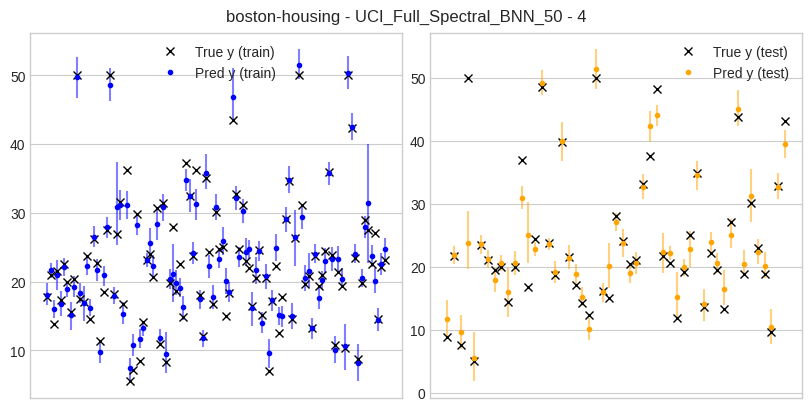

In [137]:
from matplotlib.collections import LineCollection
#fig, axs = plt.subplots(1, len(models), figsize=(8, 6*len(models)), constrained_layout=True)
#axs = axs.ravel()
SAMPLE_TO_PLOT = -1
sample_dict = samples[SAMPLE_TO_PLOT]
dataset_name = sample_dict["dataset"]
model_name = sample_dict["model"]
split_ind = sample_dict["split"]
post_draws = sample_dict["post_draws"]
method = sample_dict["method"]
batch_ndims = 2 if method == "HMC" else 1
key = jax.random.PRNGKey(SEED)

dataset_name, split_ind = sample_dict["dataset"], sample_dict["split"]

# Load dataset
X_train, y_train, X_test, y_test = get_dataset(dataset_name, int(split_ind))
X_train = X_train[::4] # only plot every 4th point
y_train = y_train[::4] # only plot every 4th point

# Load model
model = getattr(bnns.model_configs, model_name)

# Remove "y_loc" from posterior samples
post_draws.pop("y_loc", None)


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), constrained_layout=True)
fig.suptitle(f"{dataset_name} - {model_name} - {split_ind}")

predictive = Predictive(model, posterior_samples=post_draws, return_sites=["y", "y_loc"], batch_ndims=batch_ndims)
predictive = Predictive(model, post_draws, return_sites=["y_loc"], batch_ndims=batch_ndims)
predictions_train = predictive(jax.random.PRNGKey(SEED), X_train, D_Y=1)["y_loc"]
predictions_test = predictive(jax.random.PRNGKey(SEED), X_test, D_Y=1)["y_loc"]

if method == "HMC":
    predictions_train = predictions_train.squeeze()
    predictions_test = predictions_test.squeeze()

percentiles_train = jnp.percentile(predictions_train, jnp.array([5, 95]), axis=0)
percentiles_test = jnp.percentile(predictions_test, jnp.array([5, 95]), axis=0)

#rmse = jnp.sqrt(jnp.mean((predictive_ys[0,:,:,0].mean(0) - test_y) ** 2))
#percentiles = np.percentile(predictive_ys[0,:,:,0], [5, 95], axis=0)

ran_train = np.arange(predictions_train.shape[1])
axs[0].add_collection(
    LineCollection(
        zip(zip(ran_train, percentiles_train[0]), zip(ran_train, percentiles_train[1])), colors="blue", alpha=0.5
    )
)
ran_test = np.arange(predictions_train.shape[1])
axs[1].add_collection(
    LineCollection(
        zip(zip(ran_test, percentiles_test[0]), zip(ran_test, percentiles_test[1])), colors="orange", alpha=0.5
    )
)
axs[0].plot(y_train, "kx", label="True y (train)")
axs[1].plot(y_test, "kx", label="True y (test)")
axs[0].plot(predictions_train.mean(axis=0), "ko", label="Pred y (train)", color="blue", markersize=3)
axs[1].plot(predictions_test.mean(axis=0), "ko", label="Pred y (test)", color="orange", markersize=3)
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[0].legend()
axs[1].legend()


<Axes: xlabel='Model', ylabel='RMSE'>

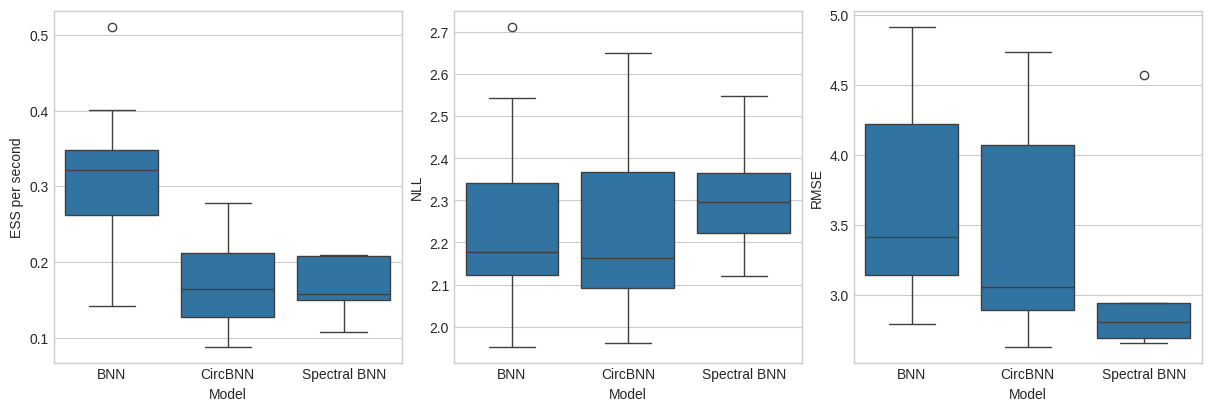

In [136]:

d = pd.DataFrame(columns=["Method", "Dataset", "Model", "# RVs", "Time spanned", "Sample throughput", "ESS", "ESS per second", "R-hat", "NLL", "RMSE"])
X_labels = {
    "UCI_BNN_50": "BNN",
    "UCI_Full_FFT_CBNN_50": "CircBNN",
    "UCI_Full_Spectral_BNN_50": "Spectral BNN",
}
for idx, sample_dict in enumerate(samples):
    if sample_dict["method"] == "SVI":
        continue
    dataset_name = sample_dict["dataset"]
    model_name = sample_dict["model"]
    split_ind = sample_dict["split"]
    post_draws = sample_dict["post_draws"].copy()
    rvs = np.array([np.array(list(value.shape[batch_ndims:])).prod() for _, value in post_draws.items()]).sum()
    method = sample_dict["method"]
    time_spanned = sample_dict["time_spanned"]
    accept_prob = sample_dict["accept_prob"]

    for key in post_draws.copy():
        if "hat" in key:
            post_draws.pop(key, None)
    summary = numpyro.diagnostics.summary(post_draws, prob=0.95)
    ess = np.array([value["n_eff"].mean() for _, value in summary.items()]).mean()
    r_hat = np.array([value["r_hat"].mean() for _, value in summary.items()]).mean()

    nll = table_df.loc[idx, "test_nll_mean"]
    rmse = table_df.loc[idx, "rmse_test_mean"]


    d.loc[len(d)] = [method, dataset_name, X_labels[model_name], rvs, time_spanned, 3500 / time_spanned, ess, ess / time_spanned, r_hat, float(nll), float(rmse)]

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), constrained_layout=True)

sns.boxplot(data=d, x="Model", y="ESS per second", ax=axs[0])
sns.boxplot(data=d, x="Model", y="NLL", ax=axs[1])
sns.boxplot(data=d, x="Model", y="RMSE", ax=axs[2])
# fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), constrained_layout=True)
# sns.scatterplot(data=d, x="Time spanned", y="ESS", hue="Model", ax=axs[0], legend=False)
# sns.scatterplot(data=d, x="ESS per second", y="NLL", hue="Model", ax=axs[1], legend=False)
# sns.scatterplot(data=d, x="ESS per second", y="RMSE", hue="Model", ax=axs[2], legend=False)
# handles, labels = axs[0].get_legend_handles_labels()

          model_name   key   ess-mean  ess-top-5  ess-bottom-5  rhat-mean  \
0  UCI_FFT_CBNN_2_50    b0  12.051931  21.453366      4.786142   1.205696   
1  UCI_FFT_CBNN_2_50    b1  21.503692  38.858752      9.465621   1.065397   
2  UCI_FFT_CBNN_2_50    b2  15.870585  15.870585     15.870585   1.093143   
3  UCI_FFT_CBNN_2_50  prec   6.192065   6.192065      6.192065   1.153682   
4  UCI_FFT_CBNN_2_50    w0  14.223204  29.366541      5.121427   1.143633   
5  UCI_FFT_CBNN_2_50    w1   8.158027  15.832812      3.393456   1.297287   
6  UCI_FFT_CBNN_2_50    w2  11.713706  30.924788      3.728744   1.237268   

   rhat-top-5  rhat-bottom-5  
0    1.698122       0.992827  
1    1.252463       0.991307  
2    1.093143       1.093143  
3    1.153682       1.153682  
4    1.571811       0.990629  
5    2.171012       0.993047  
6    1.834024       0.990644  
      model_name   key   ess-mean  ess-top-5  ess-bottom-5  rhat-mean  \
0  UCI_CBNN_2_50    b0  12.313058  22.972500      5.306839   1

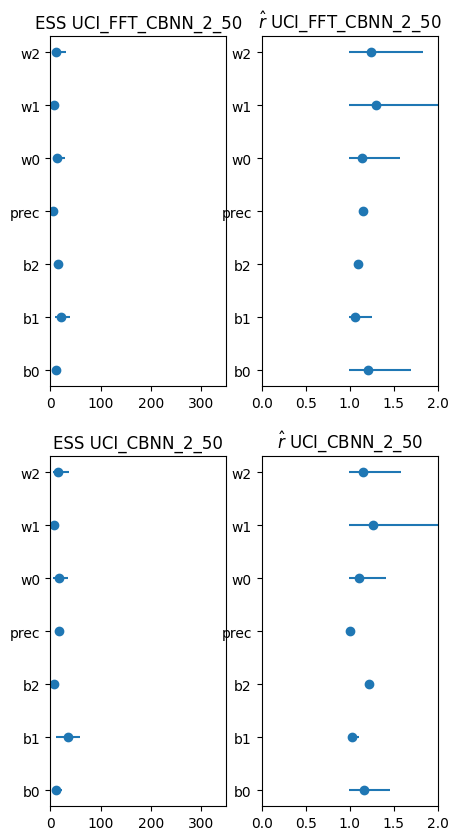

In [ ]:
fig, axs = plt.subplots(nrows=len(models), ncols=2, figsize=(5, 5*len(models)))
for i, model in enumerate(models):
    az_data = model["az_data"]
    keys = model["samples"].keys()
    # ess = az.ess(az_data)
    data = []
    for key in keys:
        rhat = numpyro.diagnostics.split_gelman_rubin(model["samples"][key])
        ess = numpyro.diagnostics.effective_sample_size(model["samples"][key])
        data.append({
            "model_name": model["model"],
            "key": str(key),
            "ess-mean": ess.mean(),
            "ess-top-5": np.percentile(ess,95),
            "ess-bottom-5": np.percentile(ess,5),
            "rhat-mean": rhat.mean(),
            "rhat-top-5": np.percentile(rhat, 95),
            "rhat-bottom-5": np.percentile(rhat, 5),
        })
    df = pd.DataFrame(data)
    # axs[i, 0].plot(df["ess-mean"], df["key"], "ko", label="mean")
    axs[i, 0].errorbar(df["ess-mean"], df["key"], xerr=[df["ess-mean"] - df["ess-bottom-5"], df["ess-top-5"] - df["ess-mean"]], fmt="o")
    axs[i, 0].set_title(f"ESS {model["model"]}")
    axs[i, 0].set_xlim([0,350])

    # axs[i, 1].plot(df["rhat-mean"], df["key"], "ko", label="mean")
    axs[i, 1].set_xlim([0,2])
    axs[i, 1].errorbar(df["rhat-mean"], df["key"], xerr=[df["rhat-mean"] - df["rhat-bottom-5"], df["rhat-top-5"] - df["rhat-mean"]], fmt="o")
    axs[i, 1].set_title(f"{r"$\hat{r}$"} {model["model"]}")
    print(df)
#sns.lineplot(data=df, x="mean", y="key", hue="model_name", dodge=True)



In [105]:
ess.data_vars["b0"].mean()

<xarray.DataArray 'b0' ()> Size: 8B
array(20.32781263)

In [35]:
jnp.sqrt(1/samples[0]["post_draws"]["prec"])

Array([1.3459997], dtype=float32)

# MCMC diagnostics

## Load metadata

In [11]:
from jax.numpy import float32, int32 , array as Array
import dill
metadatas = []
for dataset_name in os.listdir(SAMPLE_PATH):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-13:] == "metadata.dill":
                with open(os.path.join(SAMPLE_PATH, dataset_name, file_name), "rb") as f:
                    metadatas.append(dill.load(f))
metadatas

[{'accept_prob': Array([0.70137155, 0.8473585 , 0.6296817 , 0.8285232 , 0.52217454,
         0.4728051 , 0.9203443 , 0.9347981 , 0.8453467 , 0.9167628 ,
         0.66307276, 0.99957395, 0.96454936, 0.8794318 , 0.97177476,
         0.8498323 , 0.94290584, 0.5613212 , 0.95782226, 0.73588824,
         0.4502724 , 0.98605305, 0.9945368 , 0.89122164, 0.927898  ,
         0.98112166, 0.7047082 , 0.8931654 , 0.9042981 , 0.90679854,
         0.92203194, 0.9789038 , 0.9364866 , 0.80228245, 0.54777586,
         0.9496537 , 0.9604361 , 0.9231218 , 0.7594067 , 0.9978006 ,
         0.9981848 , 0.9686976 , 0.59600484, 0.9981059 , 0.7565586 ,
         0.9077806 , 0.8559679 , 0.9405323 , 0.8872966 , 0.9588449 ,
         0.9116816 , 0.9582425 , 0.92318225, 0.7000911 , 0.97630453,
         0.8865386 , 0.7572678 , 0.9467629 , 0.92078   , 0.6706086 ,
         0.95757484, 0.67371315, 0.8283383 , 1.        , 0.87685394,
         0.6303517 , 0.8845076 , 0.8168419 , 0.92428285, 0.90787536,
         0.84933865

# Acceptance probability

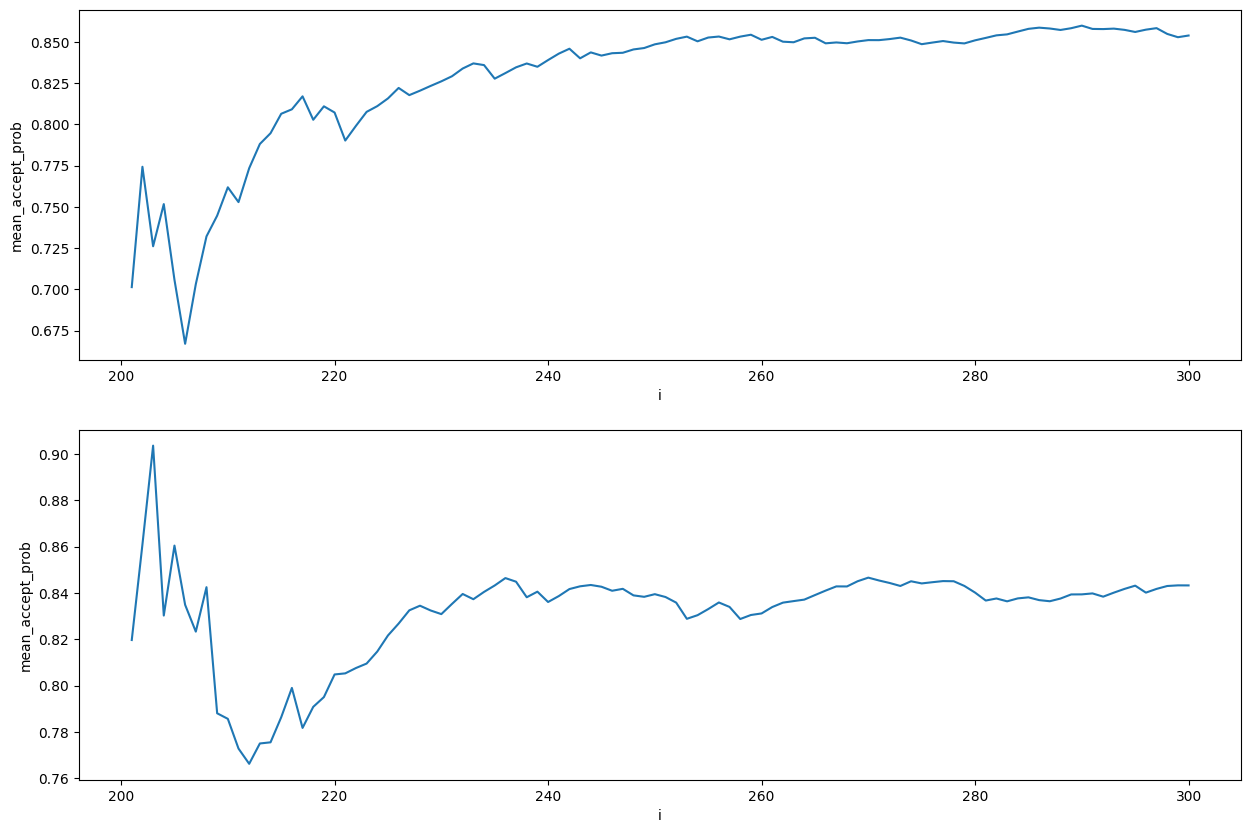

In [12]:
import seaborn as sns
fig, axs = plt.subplots(len(metadatas), 1, figsize=(15, 5*len(metadatas)))
axs = np.array([axs]) if len(metadatas) == 1 else axs
for metadata, ax in zip(metadatas, axs):
    data = pd.DataFrame(metadata)
    sns.lineplot(data=data, x="i", y="mean_accept_prob", ax=ax)

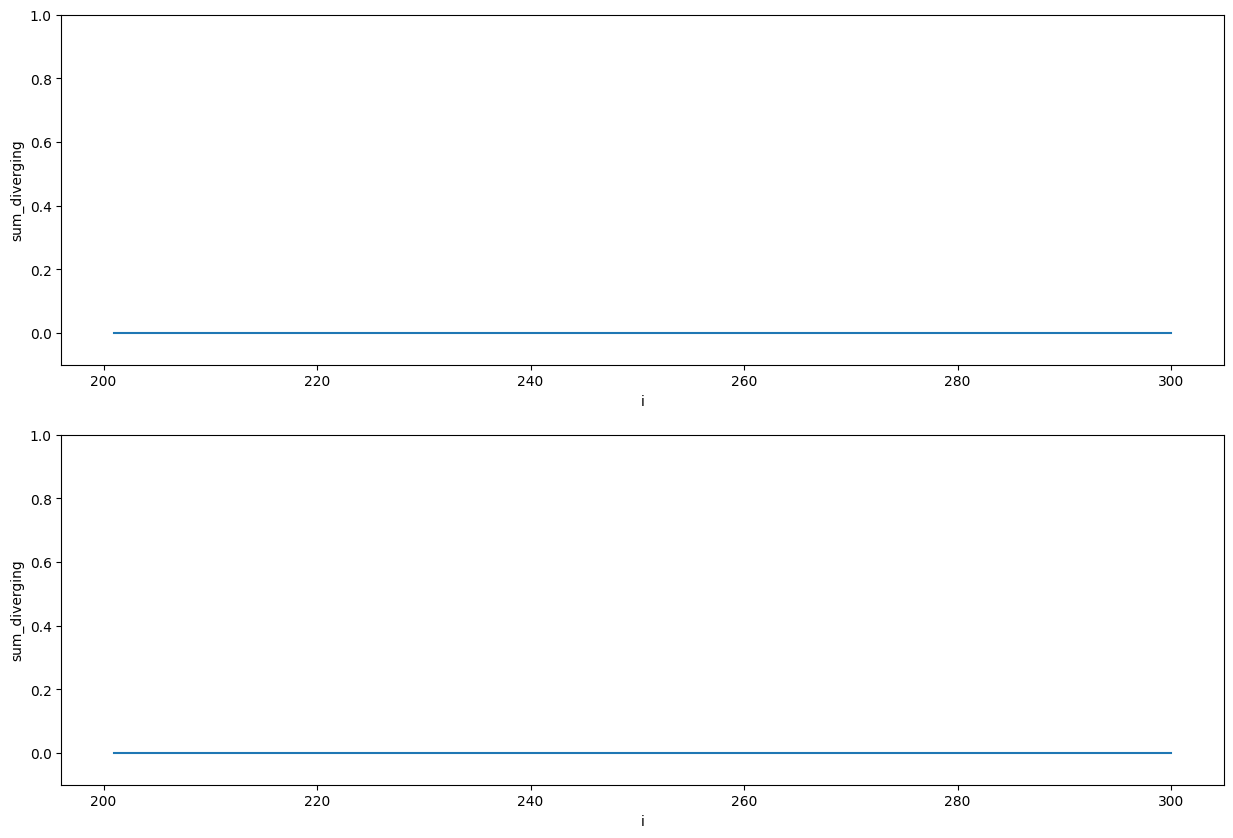

In [13]:
fig, axs = plt.subplots(len(metadatas), 1, figsize=(15, 5*len(metadatas)))
axs = np.array([axs]) if len(metadatas) == 1 else axs
for metadata, ax in zip(metadatas, axs):
    data = pd.DataFrame(metadata)
    data["sum_diverging"] = data["diverging"].cumsum()
    sns.lineplot(data=data, x="i", y="sum_diverging", ax=ax)
    ax.set_ylim([-0.1,1])

<Axes: xlabel='model_name', ylabel='time_spanned'>

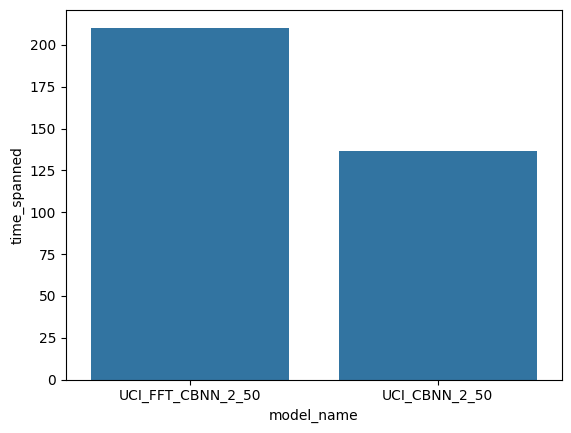

In [14]:
total_df = []
for i, metadata in enumerate(metadatas):
    metadata["model_name"] = models[i]["model"]
    total_df.append(metadata)
total_df = pd.DataFrame(total_df)
sns.barplot(data=total_df, x="model_name", y="time_spanned")

<Axes: xlabel='model', ylabel='prec'>

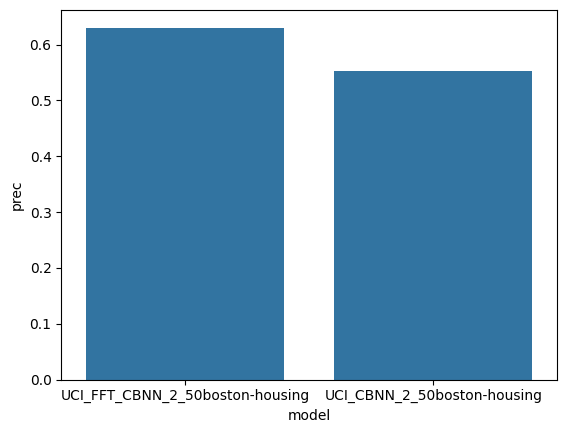

In [15]:
total_df = []
for model in models:
    total_df.append({"model": model["model"] + model["dataset"], "prec": model["samples"]["prec"].mean()})

sns.barplot(data=pd.DataFrame(total_df), x="model", y="prec")

In [15]:
jnp.sqrt(1/0.5)

Array(1.4142135, dtype=float32, weak_type=True)

# Precision prior vs posterior

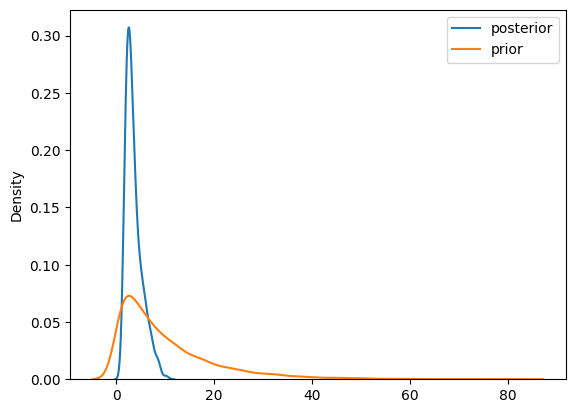

In [26]:
sns.kdeplot(data=d["samples"]["prec"].flatten(), label="posterior")
sns.kdeplot(jax.random.gamma(jax.random.PRNGKey(SEED), 1.0, (10000,))/0.1, label="prior")
plt.legend()